In [ ]:
import numpy as np

# for plotting
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

# visualize plots in the jupyter notebook
# check more https://goo.gl/U3Ai8R
%matplotlib inline

# for generating random values
import random

# for representing things like card value or colors
from enum import Enum

# for copying python objects
import copy

In [ ]:
class Color(Enum):
    RED = 0
    BLACK = 1


class Card(object):
    def __init__(self, color=None):
        self.value = self._get_random_value()
        if color == Color.BLACK or color == Color.RED:
            self.color = color
        else:
            self.color = self._get_random_color()

    def _get_random_value(self):
        """Generates integers between 1 and 10."""
        return random.randint(1, 10)

    def _get_random_color(self):
        """Generates random colors.

        Color.RED with 1/3 and Color.BLACK with 2/3 probability.
        """
        random_number = random.random()
        if random_number <= 1/3.0:
            return Color.RED
        else:
            return Color.BLACK


class Deck(object):
    def take_card(self, color=None):
        return Card(color)

In [ ]:
class State(object):
    def __init__(self, dealer_sum=0, agent_sum=0, is_terminal=False):
        self.dealer_sum = dealer_sum
        self.agent_sum = agent_sum
        self.is_terminal = is_terminal

class Action(Enum):
    STICK = 0
    HIT = 1

In [ ]:
class Player(object):
    """This is a general class for a player of Easy21."""
    def policy(self, s):
        """Given the current state choose the next action."""
        raise NotImplemented()


class Dealer(Player):
    def policy(self, s):
        """Dealers policy as described in the assigment."""
        if s.dealer_sum >= 17:
            return Action.STICK
        else:
            return Action.HIT

In [ ]:
class Environment(object):
    """An environment for the game Easy21."""
    def __init__(self):
        # the environment includes the dealer and the deck
        self.dealer = Dealer()
        self.deck = Deck()

        self.agent_max_value = 21  # max value an agent can get during the game
        self.dealer_max_value = 10  # max value the dealer can get when taking the first card
        self.actions_count = 2  # number of possible actions

    def check_bust(self, player_sum):
        return player_sum < 1 or player_sum > 21

    def generate_reward_bust(self, s):
        if s.agent_sum > s.dealer_sum:
            return 1
        elif s.agent_sum == s.dealer_sum:
            return 0
        else:
            return -1

    def take_card(self, card_color=None):
        """Returns a card from the deck."""
        Card = self.deck.take_card(card_color)
        return Card.value if Card.color == Color.BLACK else Card.value * -1

    def dealer_turn(self, s):

        action = None
        while not s.is_terminal and action != Action.STICK:
            action = self.dealer.policy(s)
            if action == Action.HIT:
                s.dealer_sum += self.take_card()
            s.is_terminal = self.check_bust(s.dealer_sum)
        return s

    def initial_state(self):
        """In the beginning both the agent and the dealer take a card."""
        return State(self.take_card(Color.BLACK), self.take_card(Color.BLACK))

    def step(self, s, a):

        # initially there's no reward and the next_s is equal to the
        # current state
        r = 0
        next_s = copy.copy(s)

        # if the player sticks then it's dealer turn
        if a == Action.STICK:
            next_s = self.dealer_turn(s)
            if next_s.is_terminal:
                r = 1
            else:
                next_s.is_terminal = True
                r = self.generate_reward_bust(next_s)
        else:
            next_s.agent_sum += self.take_card(self.deck)
            next_s.is_terminal = self.check_bust(next_s.agent_sum)

            # if end of the game then player lost: reward = -1
            if next_s.is_terminal:
                r = -1

        return next_s, r

In [ ]:
environment = Environment()

In [ ]:
class Agent(Player):
    def __init__(self, environment, No=100, discount_factor=1):
        # Player is a superclass, which means an agent implements a policy
        Player.__init__(self)

        # easy21 environment
        self.env = environment

        # we can tune these parameters
        # don't worry about this for now
        self.No = No
        self.disc_factor = discount_factor

        # V(s) is the state value function. How good is to be at state s?
        # initially we don't know
        self.V = np.zeros([self.env.dealer_max_value + 1, self.env.agent_max_value + 1])

        # this will be used to we keep track of the agent's score
        # score is a simple metric to check if the agent is getting better over time
        # score = (# of wins)/(# of games played)
        self.wins = 0.0
        self.iterations = 0.0

    def get_clear_tensor(self):

        return np.zeros((self.env.dealer_max_value + 1,
                         self.env.agent_max_value + 1,
                         self.env.actions_count))

    def choose_random_action(self):
        """We try to find the best policy possible but we act randomly sometimes."""
        return Action.HIT if random.random() <= 0.5 else Action.STICK

    def choose_best_action(self, s):
        """Returns the best action possible in state s."""
        raise NotImplemented()

    def get_max_action(self, s):
        """Returns the maxQ(s, a) between all actions."""
        return 0.0

    def get_value_function(self):
        """Get best value function in the moment."""
        for i in range(1, self.env.dealer_max_value + 1):
            for j in range(1, self.env.agent_max_value + 1):
                s = State(i, j)
                self.V[i][j] = self.get_max_action(s)
        return self.V

    def train(self, steps):
        """Train an agent for a certain number of steps.

           Args:
               steps (int): number of episodes to run.
           Returns:
               value function.
        """
        for e in range(steps):
            # do something...
            pass
        return self.get_value_function()

In [ ]:
class MCAgentEvaluation(Agent):

    def __init__(self, environment, No=100, discount_factor=1):
        Agent.__init__(self, environment, No, discount_factor)

        # N(s) is the number of times that state s has been visited
        # N(s, a) is the number of times that action a has been selected from state s.
        self.N = self.get_clear_tensor()
        # Q(s, a) is the value function. How good is to choose action a being at state s?
        self.Q = self.get_clear_tensor()
        # G_s(s) is the sum of all returns we got using this state
        self.G_s = np.zeros([self.env.dealer_max_value + 1, self.env.agent_max_value + 1])

    def get_max_action(self, s):
        return np.max(self.V[s.dealer_sum][s.agent_sum])
        #return 0.0

    def get_value_function(self):
        for i in range(1, self.env.dealer_max_value + 1):
            for j in range(1, self.env.agent_max_value + 1):
                s = State(i, j)
                self.V[i][j] = self.get_max_action(s)
        return self.V

    def predict(self, episode):
        """Given an episode. Improve the value function approximation."""
        j = 0
        for s, a, _ in episode:
            d_sum = s.dealer_sum
            a_sum = s.agent_sum
            Gt = sum([x[2] * (self.disc_factor ** i) for i, x in enumerate(episode[j:])])
            self.G_s[d_sum][a_sum] += Gt
            #print(self.G_s)
            #print(d_sum)
            #print(a_sum)
            self.V[d_sum][a_sum] = self.G_s[d_sum][a_sum] / sum(self.N[s.dealer_sum, s.agent_sum, :])
            #print(self.V)
            j += 1

    def policy(self, s):
        """Lets act like the dealer."""
        if s.agent_sum >= 17:
            action = Action.STICK
        else:
            action = Action.HIT

        self.N[s.dealer_sum][s.agent_sum][action.value] += 1
        return action

    def train(self, steps):
        for e in range(steps):
            episode = []

            # get initial state for current episode
            s = self.env.initial_state()

            while not s.is_terminal:

                # get action with epsilon greedy policy
                a = self.policy(s)

                # execute action
                next_s, r = self.env.step(copy.copy(s), a)

                # store action state and reward
                episode.append((s, a, r))

                # update state
                s = next_s

            self.iterations += 1
            # Update value function accordingly
            self.predict(episode)

        return self.get_value_function()

In [ ]:
def plot_value_function(agent, title='Value Function', generate_gif=False, train_steps=None):
    """
    Plots a value function as a surface plot, like in: https://goo.gl/aF2doj

    You can choose between just plotting the graph for the value function
    which is the default behaviour (generate_gif=False) or to train the agent
    a couple of times and save the frames in a gif as you train.

    Args:
        agent: An agent.
        title (string): Plot title.
        generate_gif (boolean): If want to save plots as a gif.
        train_steps: If is not None and generate_gif = True, then will use this
                     value as the number of steps to train the model at each frame.
    """
    # you can change this values to change the size of the graph
    fig = plt.figure(title, figsize=(10, 5))

    # explanation about this line: https://goo.gl/LH5E7i
    ax = fig.add_subplot(111, projection='3d')

    V = agent.get_value_function()

    if generate_gif:
        print('gif will be saved as %s' % title)

    #def plot_frame(ax):
        # min value allowed accordingly with the documentation is 1
        # we're getting the max value from V dimensions
    min_x = 1
    max_x = V.shape[0]
    min_y = 1
    max_y = V.shape[1]

    # creates a sequence from min to max
    x_range = np.arange(min_x, max_x)
    y_range = np.arange(min_y, max_y)

    # creates a grid representation of x_range and y_range
    X, Y = np.meshgrid(x_range, y_range)

    # get value function for X and Y values
    def get_stat_val(x, y):
        return V[x, y]
    Z = get_stat_val(X, Y)

    # creates a surface to be ploted
    # check documentation for details: https://goo.gl/etEhPP
    ax.set_xlabel('Dealer Showing')
    ax.set_ylabel('Player Sum')
    ax.set_zlabel('Value')
    ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.coolwarm,
                            linewidth=0, antialiased=False)

    def animate(frame):
        # clear the plot and create a new surface
        ax.clear()
        def plot_frame(ax):
        # min value allowed accordingly with the documentation is 1
        # we're getting the max value from V dimensions
            min_x = 1
            max_x = V.shape[0]
            min_y = 1
            max_y = V.shape[1]

            # creates a sequence from min to max
            x_range = np.arange(min_x, max_x)
            y_range = np.arange(min_y, max_y)

            # creates a grid representation of x_range and y_range
            X, Y = np.meshgrid(x_range, y_range)

            # get value function for X and Y values
            def get_stat_val(x, y):
                return V[x, y]
            Z = get_stat_val(X, Y)

            # creates a surface to be ploted
            # check documentation for details: https://goo.gl/etEhPP
            ax.set_xlabel('Dealer Showing')
            ax.set_ylabel('Player Sum')
            ax.set_zlabel('Value')
            return ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.coolwarm,
                                  linewidth=0, antialiased=False)
        surf = plot_frame(ax)
        # if we're going to generate a gif we need to train a couple of times
        if generate_gif:
            i = agent.iterations
            # cool math to increase number of steps as we go
            if train_steps is None:
                step_size = int(min(max(1, agent.iterations), 2 ** 16))
            else:
                step_size = train_steps

            agent.train(step_size)
            plt.title('%s MC score: %s frame: %s' % (title, float(agent.wins)/agent.iterations*100, frame))
        else:
            plt.title(title)

        fig.canvas.draw()
        return surf

    ani = animation.FuncAnimation(fig, animate, 32, repeat=False)

    # requires gif writer
    if generate_gif:
        ani.save(title + '.gif', writer='imagemagick', fps=3)
    else:
        plt.show()

def plot_error_vs_episode(sqrt_error, lambdas, train_steps=1000000, eval_steps=1000,
                          title='SQRT error VS episode number', save_as_file=False):
    """
    Given the sqrt error between sarsa(lambda) for multiple lambdas and
    an already trained MC control model this function plots a
    graph: sqrt error VS episode number.

    Args:
        sqrt_error (tensor): Multi dimension tensor.
        lambdas (tensor): 1D tensor.
        train_steps (int): The total steps used to train the models.
        eval_steps (int): Train_steps/eval_steps is the number of time the
                          errors were calculated while training.
        save_as_file (boolean).
    """
    # avoid zero division
    assert eval_steps != 0
    x_range = np.arange(0, train_steps, eval_steps)

    # assert that the inputs are correct
    assert len(sqrt_error) == len(lambdas)
    for e in sqrt_error:
        assert len(list(x_range)) == len(e)

    # create plot
    fig = plt.figure(title, figsize=(12, 6))
    plt.title(title)
    ax = fig.add_subplot(111)

    for i in range(len(sqrt_error)-1, -1, -1):
        ax.plot(x_range, sqrt_error[i], label='lambda %.2f' % lambdas[i])

    ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    if save_as_file:
        plt.savefig(title)
    plt.show()

def plot_error_vs_lambda(sqrt_error, lambdas, title='SQRT error vs lambda', save_as_file=False):


    # assert input is correct
    assert len(sqrt_error) == len(lambdas)

    # create plot
    fig = plt.figure(title, figsize=(12, 6))
    plt.title(title)
    ax = fig.add_subplot(111)

    # Y are the last values found at sqrt_error
    y = [s[-1] for s in sqrt_error]
    ax.plot(lambdas, y)

    ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    if save_as_file:
        plt.savefig(title)
    plt.show()

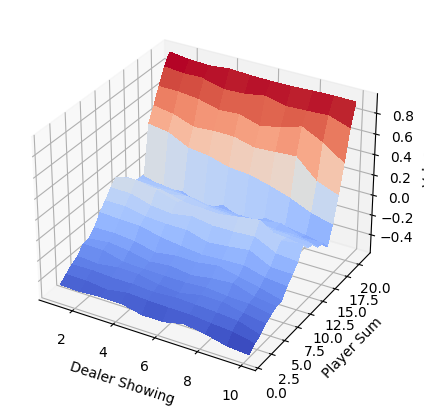

/usr/local/lib/python3.10/dist-packages/matplotlib/animation.py:884: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you output the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


In [ ]:
agent_eval = MCAgentEvaluation(environment)
agent_eval.train(100000)

plot_value_function(agent_eval, title='Value function: acting like the dealer (MC policy evaluation)')
#print(agent_eval.V)

In [ ]:
class MCAgentControl(Agent):

    def __init__(self, environment, No=100, discount_factor=1):
        Agent.__init__(self, environment, No, discount_factor)

        # Q(s, a) is the value function. How good is to choose action a being at state s?
        self.Q = self.get_clear_tensor()

        # N(s) is the number of times that state s has been visited
        # N(s, a) is the number of times that action a has been selected from state s.
        self.N = self.get_clear_tensor()

    def get_alpha(self, s, a):
        """αt = 1/N(st, at)"""
        return 1.0/(self.N[s.dealer_sum][s.agent_sum][a.value])

    def get_e(self, s):
        """e = N0/(N0 + N(st))"""
        return self.No/((self.No + sum(self.N[s.dealer_sum, s.agent_sum, :]) * 1.0))

    def get_max_action(self, s):
        return np.max(self.Q[s.dealer_sum][s.agent_sum])

    def choose_random_action(self):
        """We try to find the best policy possible but we act randomly sometimes."""
        return Action.HIT if random.random() <= 0.5 else Action.STICK

    def choose_best_action(self, s):
        return Action.HIT if np.argmax(self.Q[s.dealer_sum][s.agent_sum]) == 1 else Action.STICK

    def control(self, episode):
        """Given an episode. Improve the value function approximation towards Q*(s, a)."""
        j = 0
        for s, a, _ in episode:
            d_sum = s.dealer_sum
            a_sum = s.agent_sum

            Gt = sum([x[2]*(self.disc_factor**i) for i,x in enumerate(episode[j:])])

            self.N[d_sum][a_sum][a.value] += 1

            error = Gt - self.Q[d_sum][a_sum][a.value]
            self.Q[d_sum][a_sum][a.value] += self.get_alpha(s, a) * error

            j += 1

    def policy(self, s):
        r = random.random()
        if r <= self.get_e(s):
            action = self.choose_random_action()
        else:
            action = self.choose_best_action(s)

        return action

    def train(self, steps):
        for e in range(steps):
            episode = []

            # get initial state for current episode
            s = self.env.initial_state()

            # while game has not ended
            while not s.is_terminal:

                # get action with epsilon greedy policy
                a = self.policy(s)

                # execute action
                next_s, r = self.env.step(copy.copy(s), a)

                # store action state and reward
                episode.append((s, a, r))

                # update state
                s = next_s

            #if e % 10000 == 0 and self.iterations > 0:
               # print("Episode: %d, score: %f" % (e, (float(self.wins)/(self.iterations)*100.0)))

            # update wins and iterations
            self.iterations += 1
            if r == 1:
                self.wins += 1

            # Update Action value function accordingly
            self.control(episode)

        return self.get_value_function()

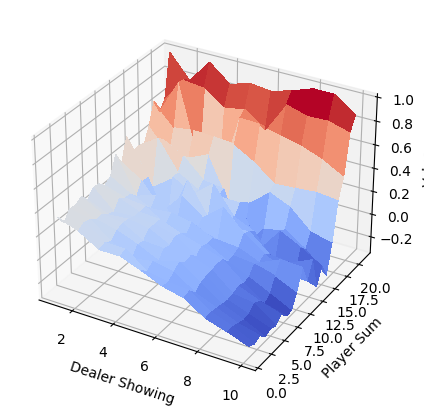

In [ ]:
mc_agent = MCAgentControl(environment)
mc_agent.train(100000)

plot_value_function(mc_agent, title="MC Control Value function No=100")

In [ ]:
class SarsaAgent(Agent):

    def __init__(self, environment, No=100, discount_factor=1, _lambda=1):
        Agent.__init__(self, environment, No, discount_factor)

        # we can tune this parameter
        self._lambda = _lambda

        # Eligibility Trace
        self.E = self.get_clear_tensor()

        # Q(s, a) is the value function. How good is to choose action a being at state s?
        self.Q = self.get_clear_tensor()

        # N(s) is the number of times that state s has been visited
        # N(s, a) is the number of times that action a has been selected from state s.
        self.N = self.get_clear_tensor()

    def get_q(self, s, a):
        return self.Q[s.dealer_sum][s.agent_sum][a.value]

    def get_alpha(self, s, a):
        """αt = 1/N(st, at)"""
        return 1.0/(self.N[s.dealer_sum][s.agent_sum][a.value])

    def get_e(self, s):
        """et = N0/(N0 + N(st))"""
        return self.No/((self.No + sum(self.N[s.dealer_sum, s.agent_sum, :]) * 1.0))

    def get_max_action(self, s):
        return np.max(self.Q[s.dealer_sum][s.agent_sum])

    def choose_best_action(self, s):
        return Action.HIT if np.argmax(self.Q[s.dealer_sum][s.agent_sum]) == 1 else Action.STICK

    def policy(self, s):
        r = random.random()
        if r <= self.get_e(s):
            action = self.choose_random_action()
        else:
            action = self.choose_best_action(s)

        self.N[s.dealer_sum][s.agent_sum][action.value] += 1
        return action

    def train(self, steps):
        for e in range(steps):
            # clear eligibility trace
            self.E = self.get_clear_tensor()

            # get initial state for current episode
            s = self.env.initial_state()

            # choose a from s with epsilon greedy policy
            a = self.policy(s)
            next_a = a

            # while game has not ended
            while not s.is_terminal:

                # execute action
                next_s, r = self.env.step(copy.copy(s), a)

                q = self.get_q(s, a)

                if not next_s.is_terminal:
                    # choose next action with epsilon greedy policy
                    next_a = self.policy(next_s)
                    q_next = self.get_q(next_s, next_a)
                    delta = r + (q_next - q) * self._lambda
                else:
                    delta = r - q * self._lambda

                self.E[s.dealer_sum][s.agent_sum][a.value] += 1
                alpha = self.get_alpha(s, a)
                update_q = alpha * delta * self.E
                self.Q += update_q
                self.E *= (self.disc_factor * self._lambda)

                # update state and action
                s = next_s
                a = next_a

            if e % 100000 == 0 and e != 0:
                print("Episode: %d, score: %f" % (e, (float(self.wins)/self.iterations)*100))

            # update wins and iterations
            self.iterations += 1
            if r == 1:
                self.wins += 1

        return self.get_value_function()

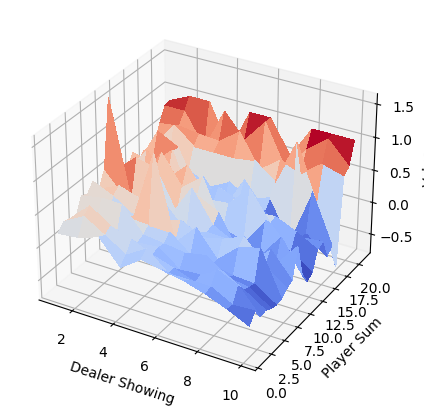

/usr/local/lib/python3.10/dist-packages/matplotlib/animation.py:884: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you output the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


In [ ]:
sarsa_agent = SarsaAgent(environment)
sarsa_agent.train(1000000)

plot_value_function(sarsa_agent, title="Sarsa No=100 lambda = 1")
np.savetxt("output.txt", sarsa_agent.V, fmt="%f", delimiter=" ")  # Use fmt="%f" for floats

In [ ]:
from google.colab import drive
drive.mount('/content/drive')